In [2]:
pip install coremltools tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 6.6 MB/s eta 0:00:00


In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report,roc_curve, auc


import coremltools as ct
import tensorflow as tf
from tensorflow.keras import layers, models

In [4]:
data = pd.read_csv(r"/JointData.csv")
data.head()

,Joint_1_x,Joint_1_y,Joint_1_z,Joint_2_x,Joint_2_y,Joint_2_z,Joint_3_x,Joint_3_y,Joint_3_z,Correct
0,-0.301760,0.700509,-2.394472,-0.375628,0.919482,-2.262781,-0.296678,1.156358,-2.165493,1
1,-0.301843,0.701633,-2.399184,-0.372513,0.921160,-2.266662,-0.291070,1.157795,-2.170853,1
2,-0.299772,0.705295,-2.399802,-0.369456,0.924926,-2.266930,-0.287693,1.161609,-2.171512,1
3,-0.297225,0.706963,-2.399491,-0.364455,0.927616,-2.267050,-0.283013,1.164751,-2.172484,1
4,-0.291665,0.709357,-2.397982,-0.357722,0.931013,-2.266630,-0.277320,1.168708,-2.172583,1


In [5]:
# Extract features (X) and labels (y)
X = data[['Joint_1_x', 'Joint_1_y', 'Joint_1_z', 'Joint_2_x', 'Joint_2_y', 'Joint_2_z', 'Joint_3_x', 'Joint_3_y', 'Joint_3_z']].values
y = data['Correct'].values

In [6]:
# Split the dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [7]:
# Reshape input data to match model's input shape
X_train_reshaped = X_train.reshape(-1, 3, 3)
X_val_reshaped = X_val.reshape(-1, 3, 3)
X_test_reshaped = X_test.reshape(-1, 3, 3)

In [8]:
def create_model(input_shape):
    model = models.Sequential([
        layers.Flatten(input_shape=input_shape),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')  # Assuming binary classification (correct/incorrect)
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [11]:
# 4. Training
model = create_model(input_shape=(3, 3))
model.fit(X_train_reshaped, y_train, epochs=10, batch_size=32, validation_data=(X_val_reshaped, y_val))
# Save the model in .h5 format
#model.save('exercise_model.h5')
model.save('my_model')

Epoch 1/10
63/63 [==============================] - 2s 11ms/step - loss: 0.6854 - accuracy: 0.5634 - val_loss: 0.6260 - val_accuracy: 0.6145
Epoch 2/10
63/63 [==============================] - 0s 6ms/step - loss: 0.6062 - accuracy: 0.6571 - val_loss: 0.5637 - val_accuracy: 0.6449
Epoch 3/10
63/63 [==============================] - 0s 4ms/step - loss: 0.5663 - accuracy: 0.6987 - val_loss: 0.5407 - val_accuracy: 0.6449
Epoch 4/10
63/63 [==============================] - 0s 3ms/step - loss: 0.5186 - accuracy: 0.7243 - val_loss: 0.4990 - val_accuracy: 0.7804
Epoch 5/10
63/63 [==============================] - 0s 3ms/step - loss: 0.4961 - accuracy: 0.7474 - val_loss: 0.4757 - val_accuracy: 0.7897
Epoch 6/10
63/63 [==============================] - 0s 4ms/step - loss: 0.4669 - accuracy: 0.7574 - val_loss: 0.4628 - val_accuracy: 0.7757
Epoch 7/10
63/63 [==============================] - 0s 3ms/step - loss: 0.4484 - accuracy: 0.7709 - val_loss: 0.4592 - val_accuracy: 0.7126
Epoch 8/10
63/63 [=

In [13]:
test_loss, test_accuracy = model.evaluate(X_test_reshaped, y_test)
print("Test Accuracy:", test_accuracy)


14/14 [==============================] - 0s 3ms/step - loss: 0.3953 - accuracy: 0.8061
Test Accuracy: 0.8060747385025024


In [18]:
y_pred_prob = model.predict(X_test_reshaped)
y_pred = (y_pred_prob > 0.5).astype(int)
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

14/14 [==============================] - 0s 3ms/step
Confusion Matrix:
[[163  83]
 [  0 182]]


In [20]:
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.66      0.80       246
           1       0.69      1.00      0.81       182

    accuracy                           0.81       428
   macro avg       0.84      0.83      0.81       428
weighted avg       0.87      0.81      0.80       428



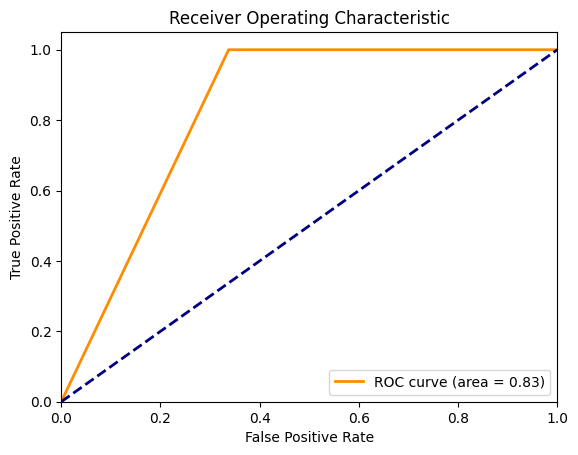

In [23]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [12]:
mlmodel = ct.convert("my_model")
mlmodel.save("my_model.mlpackage")

Running MIL backend_mlprogram pipeline: 100%|██████████| 12/12 [00:00<00:00, 3355.67 passes/s]
/usr/local/lib/python3.10/dist-packages/coremltools/converters/mil/backend/mil/load.py:581: UserWarning: Some dimensions in the input shape are unknown, hence they are set to flexible ranges with lower bound and default value = 1, and upper bound = 2. To set different values for the default shape and upper bound, please use the ct.RangeDim() method as described here: https://coremltools.readme.io/docs/flexible-inputs#set-the-range-for-each-dimension.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/coremltools/converters/mil/backend/mil/load.py:591: UserWarning: There is "None" dim in TF input placeholder. Please consider specifying input shapes by using the "inputs" param in ct.convert().
  warnings.warn(


In [ ]:
!zip -r /content/my_model.zip /content/my_model.mlpackage

  adding: content/my_model.mlpackage/ (stored 0%)
  adding: content/my_model.mlpackage/Data/ (stored 0%)
  adding: content/my_model.mlpackage/Data/com.apple.CoreML/ (stored 0%)
  adding: content/my_model.mlpackage/Data/com.apple.CoreML/weights/ (stored 0%)
  adding: content/my_model.mlpackage/Data/com.apple.CoreML/weights/weight.bin (deflated 10%)
  adding: content/my_model.mlpackage/Data/com.apple.CoreML/model.mlmodel (deflated 77%)
  adding: content/my_model.mlpackage/Manifest.json (deflated 59%)
